# Import

In [1]:
import os
import time
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, BatchNormalization, Conv2D, Conv2DTranspose, ReLU, LeakyReLU, Flatten, MaxPooling2D, Dropout, Reshape

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# GPU Initialization

In [2]:
#strategy = tf.distribute.MirroredStrategy()
#print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


DEVICES AVAILABLE: 2


# Initialization

In [3]:
BUFFER_SIZE = 64000
BATCH_SIZE = 8#*strategy.num_replicas_in_sync
batch_size = BATCH_SIZE
EPOCHS = 50
latent_dim = 128
input_size = [128, 128, 3]
image_size = (128, 128)

# Data Preprocessing

In [ ]:
#Creating dataset with ImageDataGenerator is way simpler than other methods
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
# Initially created the datatest with some augmentation, then realised, bad idea.
#     shear_range=0.2,      
#     zoom_range=0.2,       
#     horizontal_flip=True 
)

image_directory = 'D:/Data/ISIC'

dataset= datagen.flow_from_directory(
    os.path.join(image_directory, 'train'),   
    classes=['train'],   
    target_size=image_size,        
    batch_size=BATCH_SIZE,      
    class_mode='binary',
    subset='validation',
    shuffle=True
)


Found 1098 images belonging to 1 classes.


In [5]:
type(dataset)

keras.preprocessing.image.DirectoryIterator

# Generator Model

In [7]:
def gen_model():
    #OOM error>128
    ld = 28
    model = Sequential([
        Input(shape = (latent_dim,)),
        Dense(8*8*256),
        Reshape((8, 8, 256)),
        #for i in range(2,7)
        Conv2DTranspose(ld*2, kernel_size = 4, strides = 2, padding = 'same'), 
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(ld*3, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(ld*3, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(ld*4, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(ld*5, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2DTranspose(ld*6, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.1),
        Conv2D(3, kernel_size =4, padding = 'same', activation = 'sigmoid')
    ],
        name = "generator"
    )
    return model

# Discriminator Model

In [8]:
def disc_model():
    #OOM error
    nclasses = 8
    ld =28
    model = Sequential([
        Input(shape = (512,512,3)),
        Conv2D(ld, kernel_size = 4, strides= 2, padding = 'same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides = 2),
        Conv2D(ld*2, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(ld*3, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        Conv2D(ld*4, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling2D(strides=2),
        
        Flatten(),
        Dense(ld*4),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(1, activation = 'sigmoid')
    ], 
        name = "discriminator"
    )
    return model



In [9]:
# with strategy.scope(): 
#     #In order to utilize mutliple GPU, 
#     #you  must declare model, optimizers and checkpoints inside of a scope 
#     generator = gen_model()
#     discriminator = disc_model()


In [ ]:
generator = gen_model()
discriminator = disc_model()


In [10]:
generator.summary()
discriminator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 56)       229432    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 56)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 84)       75348     
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 84)        0 

In [11]:
#helper funtion to help us with loadidng images in batches
def image_loader(generator):
    for images, labels in generator:
        yield images, labels

# GAN with Custom Traning Step

In [12]:
#gan model with custom gradient calculation
class Gan(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    
    def compile(self, disc_opt, gen_opt, loss_function):
        super().compile()
        self.disc_opt = disc_opt
        self.gen_opt = gen_opt
        self.loss_function = loss_function
        self.disc_loss_metric = tf.keras.metrics.Mean(name = "disc_loss")
        self.gen_loss_metric = tf.keras.metrics.Mean(name = "gen_loss")
        
    @property
    def metrics(self):
        return [self.disc_loss_metric, self.gen_loss_metric]
    
    #custom training step
    def train_step(self, data):  # Modify the function to accept labels separately
        real_images, real_labels = data
        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Fake image decoding
        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Concatenate the real and fake labels
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        
        labels += 0.05*tf.random.uniform(tf.shape(labels))
        
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            disc_loss = self.loss_function(labels, predictions)
            
        grads  = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        
        random_latent_vectors = tf.random.normal(shape = (batch_size,self.latent_dim))
        
        misleading_labels = tf.zeros((batch_size, 1))
        
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            
            gen_loss = self.loss_function(misleading_labels, predictions)
            
        grads = tape.gradient(gen_loss, self.generator.trainable_weights)
        self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.disc_loss_metric.update_state(disc_loss)
        self.gen_loss_metric.update_state(gen_loss)
        return{
            "disc_loss": self.disc_loss_metric.result(),
            "gen_loss": self.gen_loss_metric.result()
        }
                                                 

In [13]:

def gen_images(current_epoch):
    noise = tf.random.normal([2, latent_dim])
    num_of_sample = 2
    generated_images = generator(noise, training = False)
    figure = plt.figure(figsize=(20,20))
    for i in range(generated_images.shape[0]):
        plt.subplot(2, 2,i+1)
        plt.imshow(generated_images[i, :, :, 0, ], cmap = 'gray')
        plt.title(f"After epoch {current_epoch}")        
        plt.axis('off')
    plt.savefig('After epochs{:04d}.png'.format(current_epoch))
    plt.show()

# Callbacks 

In [14]:
#callbacks. We are showing progress of gan and also saving samples after each epochs
class Gan_Callback(tf.keras.callbacks.Callback):
    def __init__(self, num_images=2, latent_dim = 128):
        self.num_images = num_images
        self.latent_dim = latent_dim       
    
    def on_epoch_end(self, epoch, logs =None):
        latent_vectors = tf.random.normal(shape = (self.num_images, latent_dim))
        generated_images = self.model.generator(latent_vectors)
#         generated_images *=255
#         generated_images.numpy()
        generated_images = (generated_images + 1) / 2.0  # Rescale the generated images to [0, 1]
        generated_images *= 255.0  # Rescale the generated images to [0, 255]
        generated_images = generated_images.numpy().astype(np.uint8)
        figure = plt.figure(figsize=(10,10))
#         for i in range(generated_images.shape[0]):
#             plt.subplot(2, 2,i+1)
#             plt.imshow(generated_images[i, :, :, 0, ], cmap='gray')
#             plt.title(f"After epoch {epoch+1}")
#             plt.axis('off')
        for i in range(generated_images.shape[0]):
            plt.subplot(2, 2, i+1)
            plt.imshow(generated_images[i])
            plt.title(f"After epoch {epoch+1}")
            plt.axis('off')
        plt.savefig('After_epochs_{:04d}.png'.format(epoch+1))
        plt.show()
        
        if(epoch % 10 ==0):
            self.model.generator.save('/kaggle/working/gen.h5')
            self.model.discriminator.save('/kaggle/working/disc.h5')

In [15]:
with strategy.scope():
    #In order to utilize mutliple GPU, 
    #you  must declare model, optimizers and checkpoints inside of a scope 
    gan = Gan(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        disc_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), 
        gen_opt=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        # Parallel gpu computing won't work unless  we pass reduction=tf.keras.losses.Reduction.NONE as a parameter too.
        loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    )


# Traning

In [16]:
#actual traing begins here
#with tf.device("/GPU:0"):
history = gan.fit(
        image_loader(dataset), 
        epochs=EPOCHS,
        steps_per_epoch=len(dataset),  
        callbacks=[Gan_Callback(num_images=4, latent_dim=latent_dim)]
    )


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


InvalidArgumentError: Graph execution error:

Detected at node 'replica_1/concat' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_27/75655756.py", line 31, in train_step
      combined_images = tf.concat([generated_images, real_images], axis=0)
Node: 'replica_1/concat'
Detected at node 'replica_1/concat' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_27/75655756.py", line 31, in train_step
      combined_images = tf.concat([generated_images, real_images], axis=0)
Node: 'replica_1/concat'
Detected at node 'replica_1/concat' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/tmp/ipykernel_27/75655756.py", line 31, in train_step
      combined_images = tf.concat([generated_images, real_images], axis=0)
Node: 'replica_1/concat'
3 root error(s) found.
  (0) INVALID_ARGUMENT:  ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [8,3,512,512] vs. shape[1] = [8,3,128,128]
	 [[{{node replica_1/concat}}]]
	 [[update_1_38/AssignAddVariableOp/_75]]
	 [[div_no_nan_1/ReadVariableOp_2/_114]]
  (1) INVALID_ARGUMENT:  ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [8,3,512,512] vs. shape[1] = [8,3,128,128]
	 [[{{node replica_1/concat}}]]
	 [[update_1_38/AssignAddVariableOp/_75]]
  (2) INVALID_ARGUMENT:  ConcatOp : Dimension 2 in both shapes must be equal: shape[0] = [8,3,512,512] vs. shape[1] = [8,3,128,128]
	 [[{{node replica_1/concat}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_10701]

In [3]:
import cv2,matplotlib.pyplot as plt

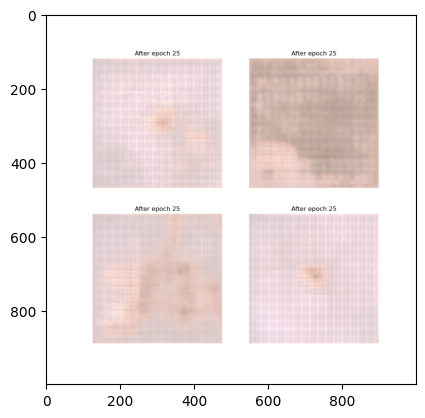

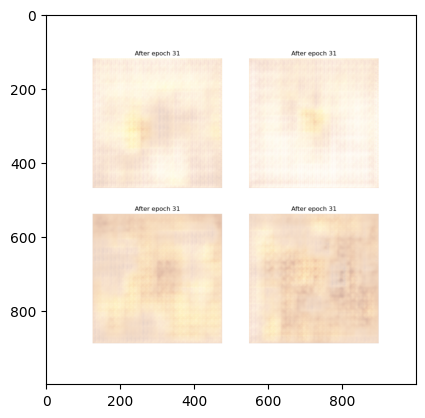

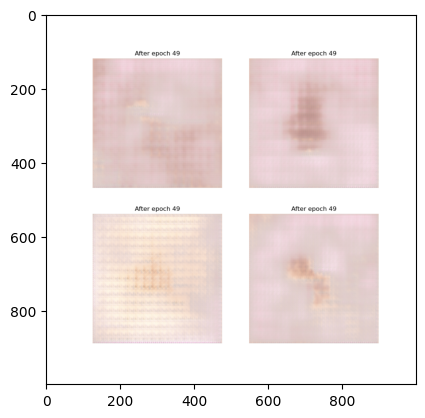

In [9]:
for i in [25,31,49]:
    plt.imshow(plt.imread(f"C:/Users/omhot/Downloads/After_epochs_00{i}.png"))
    plt.show()

# ESR

In [10]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png


ModuleNotFoundError: No module named 'tensorflow_hub'

In [ ]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [ ]:
IMAGE_PATH = "/kaggle/working/After_epochs_0031.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"
hr_image = preprocess_image(IMAGE_PATH)
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")